In [57]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import corner
import scipy.special
%matplotlib inline

In [58]:
filename = "../data/pairs_box_L205n2500TNG.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
pair_data = {}
for k in keys:
    pair_data[k] = f[k][...]
print(keys)
f.close()
print(pair_data['hubble'])

['halo_mass_A', 'halo_mass_B', 'halo_mass_G', 'hubble', 'pos_A', 'pos_B', 'pos_G', 'stellar_mass_A', 'stellar_mass_B', 'stellar_mass_G', 'vel_A', 'vel_B', 'vel_G', 'vmax_A', 'vmax_B', 'vmax_G']
0.6774


In [59]:
# sort
ii = pair_data['stellar_mass_A']>pair_data['stellar_mass_B']
for k in ['pos_A']:
    tmp = pair_data[k][ii]
    pair_data[k]

In [60]:
pair_data['vel_A_mag'] = np.sqrt(np.sum(pair_data['vel_A']**2, axis=1))
pair_data['vel_B_mag'] = np.sqrt(np.sum(pair_data['vel_B']**2, axis=1))
pair_data['vel_G_mag'] = np.sqrt(np.sum(pair_data['vel_G']**2, axis=1))

pair_data['pos_AB'] = np.sqrt(np.sum( (pair_data['pos_B'] - pair_data['pos_A'])**2, axis=1))
pair_data['vel_AB'] = np.sqrt(np.sum( (pair_data['vel_B'] - pair_data['vel_A'])**2, axis=1)) # comoving
pair_data['vel_AB_rad'] = np.sum((pair_data['pos_B'] - pair_data['pos_A'])*(pair_data['vel_B'] - pair_data['vel_A']), axis=1)/pair_data['pos_AB'] #comoving
pair_data['vel_AB_tan'] = np.sqrt((pair_data['vel_AB']**2 - pair_data['vel_AB_rad']**2))# comoving
    
#now we compute the radial velocity including the hubble flow, positions are in kpc
pair_data['vel_AB_rad'] = pair_data['vel_AB_rad'] + (pair_data['pos_AB']/1000 * pair_data['hubble']*100)

# here we compute the compute the dot product between the position vector and the radial velocity
pair_data['mu'] = np.abs(np.sum((pair_data['pos_B']-pair_data['pos_A'])*(pair_data['vel_B']), axis=1)/(pair_data['vel_B_mag']*pair_data['pos_AB']))

In [61]:
ii = pair_data['pos_AB']<10000
for k in pair_data.keys():
    if k!='hubble' and (not 'G' in k):
        pair_data[k] = pair_data[k][ii]

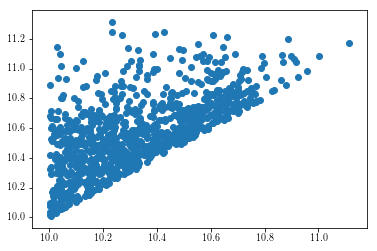

In [62]:
plt.scatter(np.log10(pair_data['stellar_mass_A']), np.log10(pair_data['stellar_mass_B']))

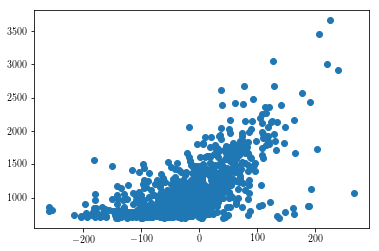

In [63]:
plt.scatter(pair_data['vel_AB_rad'], pair_data['pos_AB'])

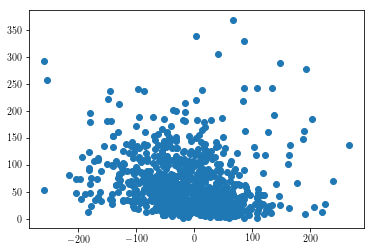

In [64]:
plt.scatter(pair_data['vel_AB_rad'], pair_data['vel_AB_tan'])

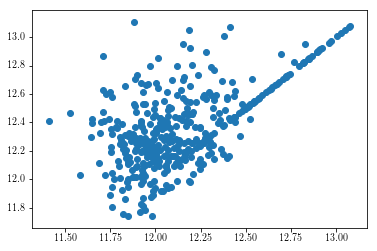

In [65]:
ii = (pair_data['vel_AB_rad']<0.0) & (pair_data['vel_AB_tan']<100)
plt.scatter(np.log10(pair_data['halo_mass_A'][ii]), np.log10(pair_data['halo_mass_B'][ii]))

In [66]:
def plot_corner_full(data, id_list=None, cut_name=None):
    local_data = data.copy()
    if id_list is not None:
        for k in data.keys():
            if k!='hubble' and (not 'G' in k):
                local_data[k] = data[k][id_list]

    print('n_points {}'.format(len(local_data['halo_mass_A'])))
    #print('unique n_points {}'.format(len(id_list)))

    local_data['log_halo_mass_A'] = np.log10(local_data['halo_mass_A'])
    local_data['log_halo_mass_B'] = np.log10(local_data['halo_mass_B'])
    local_data['log_stellar_mass_A'] = np.log10(local_data['stellar_mass_A'])
    local_data['log_stellar_mass_B'] = np.log10(local_data['stellar_mass_B'])
    local_data['log_distance'] = np.log10(local_data['pos_AB'])
    local_data['log_tan_vel'] = np.log10(local_data['vel_AB_tan'])
    local_data['log_radial_vel'] = local_data['vel_AB_rad']
    s = np.array([1.0,2.0,3.0])
    levels = 1-np.exp(-(s**2)/2.0)
    plt.figure(figsize=(8,5))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=20)
    cols = ['log_stellar_mass_A', 'log_stellar_mass_B', 'log_halo_mass_A', 'log_halo_mass_B','log_distance', 'log_radial_vel', 'log_tan_vel']
    array_data = np.ones((len(local_data[cols[0]]), len(cols)))
    for i,c in enumerate(cols):
        array_data[:,i] = local_data[c]
    
    truth = np.array([np.log10(6.08E10), np.log10(10.3E10), np.log10(1.5E12), np.log10(5E12), np.log10(770), -109.0, np.log10(34.3)])
    labels=[r"$\log_{10} M_{\star,A}$", r"$\log_{10} M_{\star,B}$", 
                        r"$\log_{10} M_{DM,A}$", r"$\log_{10} M_{DM,B}$",
                        r"$\log_{10} D$", r"$V_{r}$", r"$\log_{10} |V_{t}|$"]
        
    _ = corner.corner(array_data,labels=labels,levels=levels, truths=truth,
                      quantiles=[0.16, 0.5, 0.84], alpha=0.01, figsize=(10, 10), 
                      title_kwargs={"fontsize": 14},  show_titles=True)

   # if cut_name is None:
   #     filename = '../paper/full_corner_{}.pdf'.format(sim_name)
   # else:
   #     filename = '../paper/full_corner_{}_{}.pdf'.format(sim_name, cut_name)
        
   # plt.savefig(filename)

n_points 902


<Figure size 576x360 with 0 Axes>

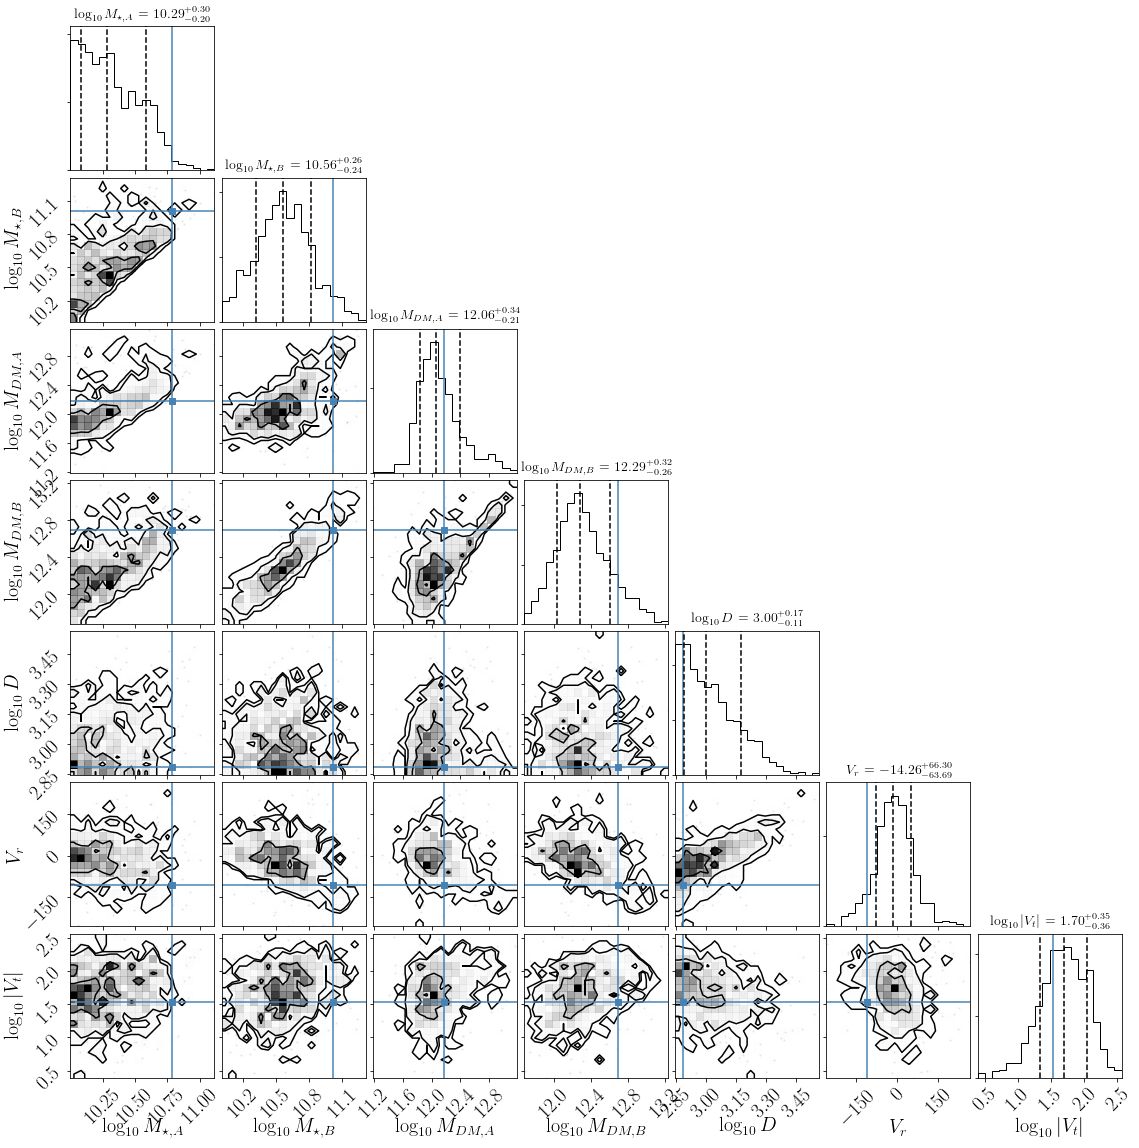

In [67]:
plot_corner_full(pair_data)

In [163]:
def logproba(x, mean_x=6.08E10, sigma_x=1.14E10):
    d = (mean_x - x)/sigma_x
    d = np.exp(-0.5 * (d))
    return d

def integrated_normal_inv(min_x, max_x, n_points, mean_x=6.08E10, sigma_x=1.14E10):
    c = 1/(2.0 * sigma_x ** 2)
    
    q = (min_x-mean_x) 
    min_erf = scipy.special.erf(q * np.sqrt(c))

    q = (max_x-mean_x)
    max_erf = scipy.special.erf(q * np.sqrt(c))
    
    #print(min_erf, max_erf)
    x = np.linspace(min_erf, max_erf, n_points)
    
    y = scipy.special.erfinv(x)/np.sqrt(c) + mean_x
    
    y[np.isinf(y)] = max_x
    return x+1, y
#x, y=integrated_normal_inv(1E10, 10E10, 100)#, mean_x=10, sigma_x=2.0)

#plt.scatter(x, y)
#print(y)

def bootstrap(data):
    stellar_mass = data['stellar_mass_A']
    n_points = len(stellar_mass)
    ids = np.ones(n_points, dtype=int)
    
    cdf_grid, mass_grid  = integrated_normal_inv(np.min(stellar_mass), np.max(stellar_mass), n_points)
    for i in range(n_points):
        d = np.abs(stellar_mass-mass_grid[i])
        ids[i] = np.argmin(d)
    plt.hist(stellar_mass[ids], bins=20)
    plt.hist(mass_grid, bins=20, alpha=0.5)

    plot_corner_full(data, id_list=ids, cut_name='star_mass_A')

n_points 902


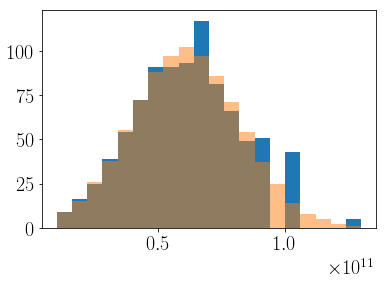

<Figure size 576x360 with 0 Axes>

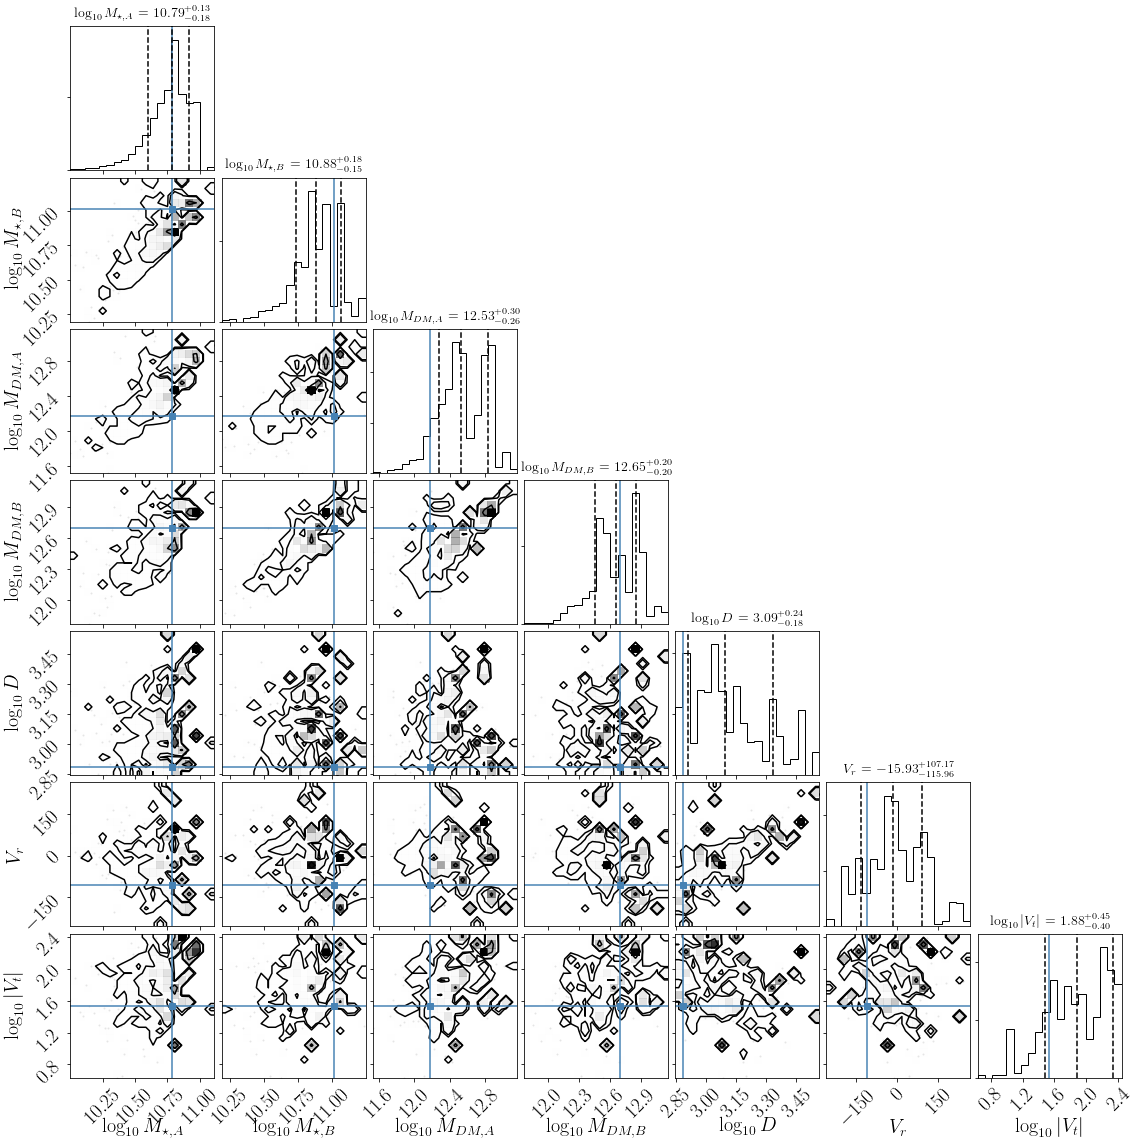

In [164]:
bootstrap(pair_data)

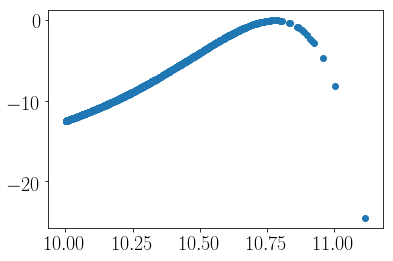

In [129]:
mean = 6E10
sigma = 1E10
pesos = (-(pair_data['stellar_mass_A']-mean)**2/(2.0*sigma**2)) 
plt.scatter(np.log10(pair_data['stellar_mass_A']), pesos)

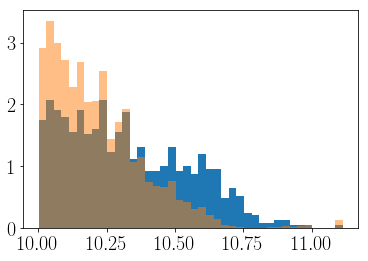

In [130]:
_ = plt.hist(np.log10(pair_data['stellar_mass_A']), density=True, bins=40)
_ = plt.hist(np.log10(pair_data['stellar_mass_A']), weights=pesos, density=True, alpha=0.5, bins=40)

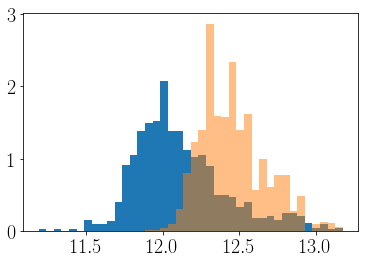

In [105]:
_ = plt.hist(np.log10(pair_data['halo_mass_A']), density=True, bins=40)
_ = plt.hist(np.log10(pair_data['halo_mass_A']), weights=pesos, density=True, alpha=0.5, bins=40)

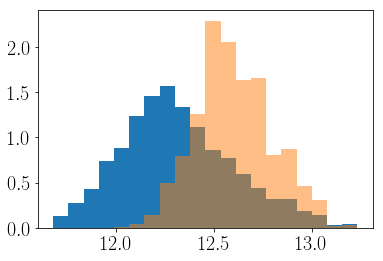

In [113]:
_ = plt.hist(np.log10(pair_data['halo_mass_B']), density=True, bins=20)
_ = plt.hist(np.log10(pair_data['halo_mass_B']), weights=pesos, density=True, alpha=0.5, bins=20)

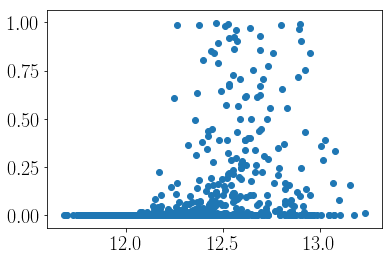

In [107]:
plt.scatter(np.log10(pair_data['halo_mass_B']), pesos)

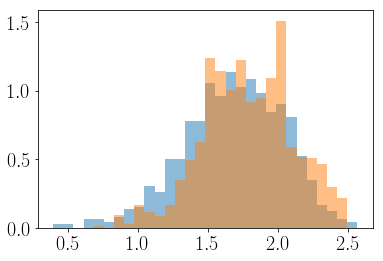

In [108]:
_ = plt.hist(np.log10(pair_data['vel_AB_tan']), density=True, alpha=0.5, bins=30)
_ = plt.hist(np.log10(pair_data['vel_AB_tan']), weights=pesos, density=True, alpha=0.5, bins=30)

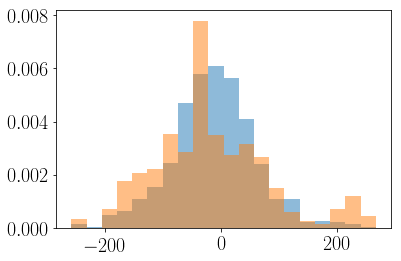

In [112]:
_ = plt.hist((pair_data['vel_AB_rad']), density=True, alpha=0.5, bins=20)
_ = plt.hist((pair_data['vel_AB_rad']), weights=pesos, density=True, alpha=0.5, bins=20)

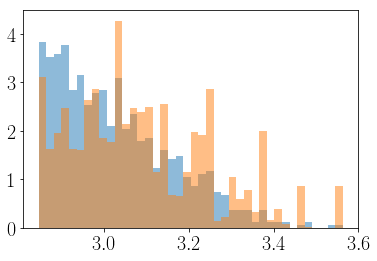

In [110]:
_ = plt.hist(np.log10(pair_data['pos_AB']), density=True, alpha=0.5, bins=40)
_ = plt.hist(np.log10(pair_data['pos_AB']), weights=pesos, density=True, alpha=0.5, bins=40)

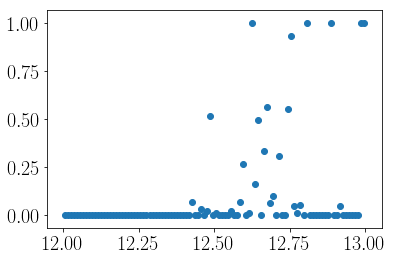

In [155]:
n_bins = 100
halo_mass_bins = np.linspace(12.0, 13.0, n_bins+1)
halo_mass_center = 0.5 * (halo_mass_bins[1:] + halo_mass_bins[:-1])
proba = np.ones(n_bins)
for i in range(n_bins):
    ii = (np.log10(pair_data['halo_mass_A'])>halo_mass_bins[i]) & (np.log10(pair_data['halo_mass_A'])<halo_mass_bins[i+1])
    proba[i] = np.sum(pesos[ii])
plt.scatter(halo_mass_center, np.exp(proba))
#np.log10(pair_data['halo_mass_B']), pesos)